This notebook analyzes the data with the answers to the questionnaires received from the teachers. The objective is to clean the data, perform exploratory data analysis and create some plots that can appear in the paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_excel ('data/respuestas_cuestionario_euskera.xlsx', engine='openpyxl',
                    header=0, nrows=48, usecols='C:AT')
df.tail()

,Zein da irakasten duzun irakasgai nagusia?,Zenbat urteko esperientzia duzu irakaskuntzan?,"Lan egiten duzun ikastetxean, batez beste, zenbat ikasle dago gela bakoitzean?",Zein da zure ikasgelen hezkuntza-maila?,Zein eskola motatan irakasten duzu?,Dinamizatzailea zara zure eskolan?,Zenbat telefono mugikor daude zure ikastetxean?,Zenbat tablet?,Zenbat mahai gaineko ordenagailu?,Zenbat ordenagailu eramangarri?,...,"Beharrezkoa ikusten baduzu, azalduko zenuke zergatik (edo zergatik ez)?",Zein funtzionalitate interesatzen zaizkizu gehien errealitate areagotuko aplikazio batean?,"Beharrezkoa ikusten baduzu, azaldu zure hautua:","Errealitate areagotuko hezkuntza-edukiak sortzeko aplikazio bat izango bazenu, zure app propioa sortzeko erabiliko zenuke?",Zer motatako hezkuntza-edukiak sortuko zenituzke aplikazio horrekin?,"Arete proiektu europarraren barruan, elkarlaneko errealitate areagotuko aplikazioak erraz sortzeko aukera ematen duen tresna bat garatzen ari gara. Nola uste duzu erabil zenezakeela teknologia hori zure lanean?","Beharrezkoa ikusten baduzu, gehitu iruzkin bat:","Arete proiektu europarrean adimen artifizialeko aplikazioak ere garatzen ari gara, irakasleen lana errazteko. Nola uste duzu erabil zenezakeela adimen artifiziala zure lanean?","Beharrezkoa ikusten baduzu, gehitu iruzkin bat:.1",Ba al dago gurekin partekatu nahi duzun beste komentariorik irakaskuntzan errealitate areagotua erabiltzeari buruz?
42,"Haur Hezkuntzan nago, ez dago irakasgai nagus...",20 urte,20,Haurreskola,Ikastolan,Ez,NaN,NaN,NaN,NaN,...,NaN,Pertsona batek baino gehiagok aplikazioa aldi ...,NaN,Bai,"Bideoak non ikaslea mulgildu daitekeen, Simula...","Elkarlaneko jolasak sortzea, Edukia sortzea ik...",NaN,Etapa goiztiarretan ikasgai bat ez gainditzeko...,NaN,NaN
43,"Euskara, Gaztelania; Gizarte Zientziak, Matema...",40 urte,25 inguru,Bigarren Hezkuntza,Ikastolan,Ez,NaN,NaN,NaN,NaN,...,Ikasleak askoz ere gusturago ikasten dutelako.,Aplikazioarekin elkarreragiteko aukera izatea ...,NaN,Bai,"Bideoak non ikaslea mulgildu daitekeen, Simula...",Galderak egiteko eta ikasleen erantzunak denbo...,NaN,Test batean ikasleek ematen dituzten erantzuna...,NaN,NaN
44,HIZKUNTZAK,37,Laguntza behar dutenekin aritzen naiz eta gehi...,Bigarren Hezkuntza,Ikastolan,Ez,NaN,NaN,NaN,NaN,...,NaN,Ikasleen arteko eta ikasleen eta irakasleen ar...,NaN,Bai,"Quiz/Test, Blogs",Galderak egiteko eta ikasleen erantzunak denbo...,NaN,Ez dakit nola erabiliko nuken.,NaN,NaN
45,Matematika,21,26,Lehen Hezkuntza,Ikastolan,Bai,Ez dakit,2,20 bat,600 bat,...,NaN,Aplikazioarekin elkarreragiteko aukera izatea ...,NaN,Bai,"Bideoak non ikaslea mulgildu daitekeen, Simula...",Galderak egiteko eta ikasleen erantzunak denbo...,NaN,Test batean ikasleek ematen dituzten erantzuna...,NaN,NaN
46,Teknologia,3 urte,20,Bigarren Hezkuntza,Ikastolan,Ez,NaN,NaN,NaN,NaN,...,Ikasleei beste erreminta desberdin bat ematen ...,"Edukia pertsonalizatzeko aukera izatea, Pertso...",NaN,Bai,"Simulazioak, Bistaratzeak (2D edo 3D)",Galderak egiteko eta ikasleen erantzunak denbo...,NaN,Etapa goiztiarretan ikasgai bat ez gainditzeko...,NaN,NaN


In [3]:
print(df.shape)

(47, 44)


Ok, we are good. 47 responses, and the answers spread over 44 columns. Not all the cells are filled, as the questionnaire had branches.
As we will be using Seaborn several times to create bar plots, it make sense to define a function that we will call when creating the figures

In [4]:
def create_bar_plot(plot_data, x_label, y_label, out_image_name=None, space=0.3):
    sns.set(rc={'figure.figsize':(15, 7)})
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":22})

    g = sns.barplot(x=x_label, y=y_label, data=plot_data, palette="mako")
    g.bar_label(g.containers[0], padding=4, fontsize=12)
    
#     for p in g.patches:
#                 _x = p.get_x() + p.get_width() + float(space)
#                 _y = p.get_y() + p.get_height() - float(space)
#                 value = int(p.get_width())
#                 g.text(_x, _y, value, ha="left")

    plt.xticks( 
        fontweight='normal',
        fontsize='xx-large'
    )

    plt.yticks(
        rotation=30,
        fontweight='normal',
        fontsize='xx-large'
    )
    
    g.set(ylabel=None)
    plt.title(y_label, size=26)

    plt.tight_layout()
    if out_image_name:
        plt.savefig(out_image_name, dpi=300)

#### Subject
We can now start by checking the subject taught by the respondents. 

In [5]:
subjects_resp = df['Zein da irakasten duzun irakasgai nagusia?'].value_counts()
print(subjects_resp)

Teknologia                                                                                 6
Matematika                                                                                 4
Biologia                                                                                   3
Euskara                                                                                    2
Ingelesa                                                                                   2
Gaztelania                                                                                 2
Irakasgai guztiak ingelesa ezik.                                                           1
Matematika eta Teknologia                                                                  1
PROI (proiektuak)                                                                          1
Osasungintza                                                                               1
Fisika                                                                

There is some work to do before plotting. We will split into different subjects and, if a teacher mentioned more than one, we will assign him to both subjects. That, unless he teaches many subjects (in that case we will assign **"all"**). Some uncommon subjects, like *osasungintza* or *proiectuak* will be grouped together as **"other"**

In [6]:
subjects_modified = {"Technology":0, "Math":0, "Physics and Chemistry":0, "Biology":0, "Crafts":0,
                     "First Language":0, "Foreign Language":0, "History and Philosophy":0, "All":0, "Other": 0}
subjects_dict = dict(subjects_resp)
subjects_modified["Technology"] = subjects_dict["Teknologia"] +\
                                  subjects_dict["Teknologia, matematika , natur zientziak"] +\
                                  subjects_dict["Natur zientziak , Matematika, Teknologia"] +\
                                  subjects_dict["Matematika eta Teknologia"]

subjects_modified["Math"] = subjects_dict['Matematika'] +\
                            subjects_dict['Mate'] +\
                            subjects_dict["Teknologia, matematika , natur zientziak"] +\
                            subjects_dict["Natur zientziak , Matematika, Teknologia"] +\
                            subjects_dict["Matematika eta Teknologia"] +\
                            subjects_dict["Matematika eta fisika eta kimika"]

subjects_modified["Physics and Chemistry"] = subjects_dict["Fisika-Kimika"] +\
                                             subjects_dict["Teknologia, matematika , natur zientziak"] +\
                                             subjects_dict["Natur zientziak , Matematika, Teknologia"] +\
                                             subjects_dict["Matematika eta fisika eta kimika"] +\
                                             subjects_dict["natur zientziak"] +\
                                             subjects_dict["Naturaren zientziak"]

subjects_modified["Biology"] = subjects_dict["Biologia"] + subjects_dict["BIOLOGIA-GEOLOGIA"] +\
                               subjects_dict["Biologia-Geologa"]

subjects_modified["First Language"] = subjects_dict["Euskara"] + subjects_dict["HIZKUNTZAK"]

subjects_modified["Foreign Language"] = subjects_dict["Gaztelania"] + subjects_dict["Ingelesa"] +\
                                        subjects_dict["Frantsesa"] + subjects_dict["Gaztelania eta literatura"]

subjects_modified["History and Philosophy"] = subjects_dict["Historia"] + subjects_dict["Filosofia"]

subjects_modified["Crafts"] = subjects_dict["Plastika"] + subjects_dict["Plastika eta Ikus Hezkuntza"]

subjects_modified["All"] = 5 # Rows 1, 31, 32, 40, 43

subjects_modified["Other"] = 4 # Rows 17, 23, 24, 35

subjects = pd.DataFrame.from_dict(subjects_modified, orient='index', columns=['Teachers'])
subjects.reset_index(inplace=True)
subjects = subjects.rename(columns={"index":"Subject"})
subjects

,Subject,Teachers
0,Technology,9
1,Math,9
2,Physics and Chemistry,6
3,Biology,5
4,Crafts,2
5,First Language,3
6,Foreign Language,6
7,History and Philosophy,2
8,All,5
9,Other,4


We are now ready to create the visualization. We use Seaborn for this, and we will create an horizontal bar plot.

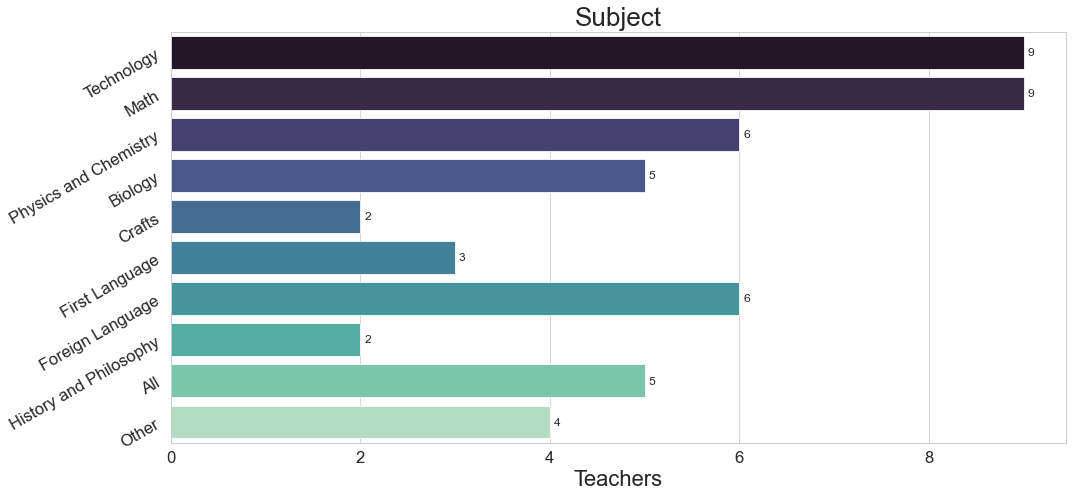

In [7]:
create_bar_plot(subjects, 'Teachers', 'Subject', 'figures/subjects.svg', space=0.1)

We are gonna skip the years of experience of the teachers (at least for now). The next thing we want to check is the number of students per teacher.

#### Students

In [8]:
students_resp = df['Lan egiten duzun ikastetxean, batez beste, zenbat ikasle dago gela bakoitzean?']
students_resp

0                                                    25
1                                                    27
2                                                    15
3                                                    25
4                                                    24
5                                                    25
6                                                    22
7                                                    17
8                                                    26
9                                                    25
10                                40 (bi irakaslerekin)
11                                                   25
12                                                   19
13                                                   30
14                                                   26
15                                                   20
16                                  18 gutxi gorabehera
17                                              

Let's fix the different representations: We change elements 28 and 40, to only show the first number. We also remove element 44, as no numbers are specified. Finally, we change values including text by stripping all non-digits characters.

In [9]:
students_resp[28] = 25
students_resp[40] = 20
students_resp.drop(index=44, inplace=True)
students_resp.replace(r'[^\d.]+', '',regex=True, inplace = True)

students_resp = students_resp.astype(int)
        
#students_resp = students_resp.value_counts()

/var/folders/mb/gp2pv4vs4tb05cb9df4whm7r0000gn/T/ipykernel_22258/4174568543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students_resp[28] = 25
/var/folders/mb/gp2pv4vs4tb05cb9df4whm7r0000gn/T/ipykernel_22258/4174568543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students_resp[40] = 20


Ok, now let's plot a histogram representing the number of students per teacher

<Figure size 1080x504 with 0 Axes>

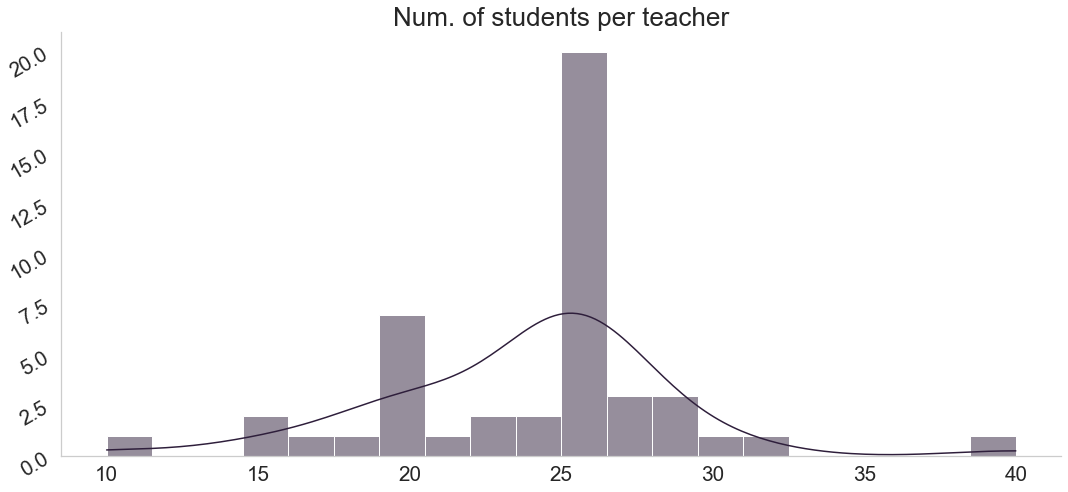

In [10]:
tmp = pd.DataFrame({'Students': students_resp})

sns.set(rc={'figure.figsize':(15, 7)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.despine()
sns.set_palette(sns.color_palette("mako"))

g = sns.displot(tmp, x="Students", kind="hist", kde=True, bins=20)

plt.xticks( 
    fontweight='normal',
    fontsize='xx-large'
)

plt.yticks(
    rotation=30,
    fontweight='normal',
    fontsize='xx-large'
)

g.set(ylabel=None)
g.set(xlabel=None)
plt.title("Num. of students per teacher", size=26)

fig = plt.gcf()
fig.set_size_inches( 15, 7)

plt.tight_layout()
plt.savefig('figures/hist_students.svg', dpi=300)

Now we try plotting a Likert scale related to question 23 (Level of satisfaction using AR at school)

In [11]:
q23 = df.iloc[:,21] #21 because we discarded the first two questions when importing the answers

In [12]:
q23

0     NaN
1     3.0
2     NaN
3     NaN
4     NaN
5     1.0
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    2.0
28    NaN
29    NaN
30    NaN
31    NaN
32    1.0
33    NaN
34    NaN
35    NaN
36    NaN
37    4.0
38    NaN
39    NaN
40    NaN
41    NaN
42    NaN
43    NaN
44    NaN
45    NaN
46    NaN
Name: Nola ebaluatuko zenuke zure asebetetze-maila, irakaskuntzan errealitate areagotua erabiliz? , dtype: float64